In [88]:
import pandas as pd
import numpy as np
import functools
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import functools

from utils import calcular_estatisticas, imprimir_estatisticas
from scipy.stats import ttest_ind_from_stats

from joblib import Parallel, delayed


In [43]:
df = pd.read_csv('Video_games_esrb_rating.csv')
df.head()

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


In [44]:
df = df.drop('title', axis=1)

X = df.drop('esrb_rating', axis=1)
y = df['esrb_rating'].values

X.head()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [45]:
pca = PCA(n_components=2)

pca.fit(X)


X_pca = pca.transform(X)

X_pca_df = pd.DataFrame(X_pca, columns=['PC0', 'PC1'])

X_pca_df.head() 
# X = X.values

,PC0,PC1
0,-0.565610,-0.642572
1,-0.566661,-0.099867
2,-0.590105,0.903231
3,0.938775,-0.271937
4,0.934845,-0.071076


<AxesSubplot:xlabel='PC0', ylabel='PC1'>

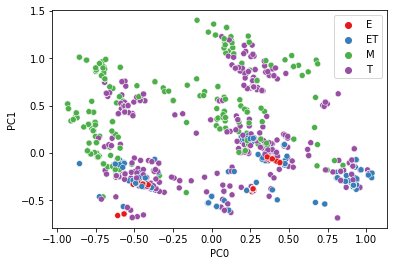

In [46]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue=y, palette='Set1')

In [89]:
def rejeitar_hip_nula(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2, alpha=0.05):
    _, pvalor = ttest_ind_from_stats(media_amostral1, desvio_padrao_amostral1, n1, media_amostral2, desvio_padrao_amostral2, n2)
    return pvalor <= alpha

In [47]:
def selecionar_melhor_modelo(classificador, X_treino, X_val, y_treino, 
                             y_val, n_jobs=4, 
                             cv_folds=None, params={}):
    
    def treinar_modelo(X_treino, X_val, y_treino, y_val, params):
        clf = classificador(**params)
        clf.fit(X_treino, y_treino)
        pred = clf.predict(X_val)
        
        if len(set(y_treino)) > 2:
            return f1_score(y_val, pred, average='weighted')
        else:
            return f1_score(y_val, pred)
    
    
    if cv_folds is not None:
        #Se for pra usar validação cruzada, usar GridSearchCV
        score_fn = 'f1' if len(set(y_treino)) < 3 else 'f1_weighted'
        
        clf = GridSearchCV(classificador(), params, cv=cv_folds, n_jobs=n_jobs, scoring=score_fn)
        #Passar todos os dados (Treino e Validação) para realizar a seleção dos parâmetros.
        clf.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
        
        melhor_comb = clf.best_params_
        melhor_val = clf.best_score_
        
    else:
        param_grid = list(ParameterGrid(params))
        
        f1s_val = Parallel(n_jobs=n_jobs)(delayed(treinar_modelo)
                                         (X_treino, X_val, y_treino, y_val, p) for p in param_grid)

        melhor_val = max(f1s_val)
        melhor_comb = param_grid[np.argmax(f1s_val)]
        
        clf = classificador(**melhor_comb)
        
        clf.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return clf, melhor_comb, melhor_val

In [48]:
def do_cv(classificador, X, y, cv_splits, param_cv_folds=None,
         n_jobs=2, scale=False, params={}):
    
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    f1s = []
    predictions = []
    list_confusion_matrix = []
    list_melhor_comb = []
    
    # pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)
        
        if scale:
            ss = StandardScaler()
            X_treino = ss.fit_transform(X_treino)
            X_teste = ss.transform(X_teste)
            X_val = ss.transform(X_val)        

        modelo, melhor_comb, _ = selecionar_melhor_modelo(classificador, X_treino, X_val, y_treino, y_val, 
                                                      n_jobs=n_jobs, cv_folds=param_cv_folds, params=params)
        pred = modelo.predict(X_teste)
        predictions.append(pred)

        print(classification_report(y_teste, pred))

        print(set(y_treino))
        
        if len(set(y_treino)) > 2:
            f1 = f1_score(y_teste, pred, average='weighted')
        else:
            f1 = f1_score(y_teste, pred)
        f1s.append(f1)
        
        print(f'{melhor_comb} -- {f1}')
        list_melhor_comb.append(melhor_comb)

        list_confusion_matrix.append(confusion_matrix(y_teste, pred))
        
        # pgb.update(1)
        
    # pgb.close()
    
    return f1s, list_confusion_matrix, list_melhor_comb

In [49]:
arvore_decisao, list_confusion_matrix, list_melhor_comb = do_cv(DecisionTreeClassifier, X_pca_df.values, y, 10, 5, 2, False,  {'min_samples_leaf' : [3, 5, 10, 15, 20, 30],
                    'min_samples_split' : [3, 5, 10, 15, 20, 30],
                    'max_depth' : [2, 3, 4, 5]})

              precision    recall  f1-score   support

           E       0.91      0.69      0.78        42
          ET       0.50      0.62      0.56        40
           M       0.65      0.62      0.63        39
           T       0.61      0.62      0.61        69

    accuracy                           0.64       190
   macro avg       0.67      0.64      0.65       190
weighted avg       0.66      0.64      0.64       190

{'M', 'T', 'ET', 'E'}
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 5} -- 0.6429391282853887
              precision    recall  f1-score   support

           E       0.77      0.98      0.86        42
          ET       0.81      0.75      0.78        40
           M       0.78      0.54      0.64        39
           T       0.70      0.74      0.72        69

    accuracy                           0.75       190
   macro avg       0.77      0.75      0.75       190
weighted avg       0.76      0.75      0.75       190

{'M', 'T', 'ET', 'E'}


In [92]:
imprimir_estatisticas(arvore_decisao)

mediaArvDecisaotMelhor = np.mean(arvore_decisao[np.argmax(arvore_decisao)])
desvioArvDecisaoMelhor = np.std(arvore_decisao[np.argmax(arvore_decisao)])

mediaArvDecisaoPior = np.mean(arvore_decisao[np.argmin(arvore_decisao)])
desvioArvDecisaoPior = np.std(arvore_decisao[np.argmin(arvore_decisao)])


Resultados: 0.70 +- 0.03, min: 0.64, max: 0.75


In [93]:
# Aplica teste T entre os melhores e piores resultados obtidos
rejeitar_hip_nula(mediaArvDecisaotMelhor, desvioArvDecisaoMelhor, len(arvore_decisao), mediaArvDecisaoPior, desvioArvDecisaoPior, len(arvore_decisao))

True

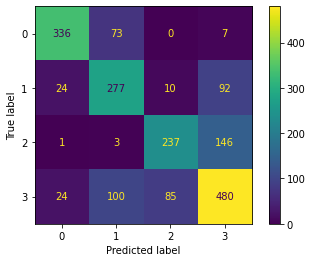

In [51]:
reduceMatrix = functools.reduce(lambda x,y :  x + y, list_confusion_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=reduceMatrix)
disp.plot()

In [52]:
melhor_comb = list_melhor_comb[np.argmax(arvore_decisao)]
print(list_melhor_comb[np.argmax(arvore_decisao)])

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 5}


In [53]:
melhor_comb['min_samples_split']

5

In [54]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [55]:
ad = DecisionTreeClassifier(**melhor_comb)

ad.fit(X, y)



DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=5)

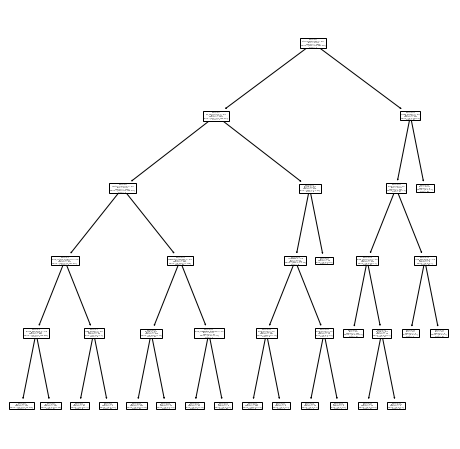

In [56]:
plt.figure(figsize=(8,8))
plot_tree(ad, class_names=ad.classes_, feature_names=X.columns, node_ids=True)
plt.savefig('Arvore.svg')
plt.show()

# Estrutura de regras de decisão induzidas

In [57]:
X

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,1,0,0,0,0,0
1891,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1893,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
predClass = []

for linha in X.index:
    if X['strong_janguage'][linha] <= 0.5:

        if (X['no_descriptors'][linha] <= 0.5):
        
            if (X['fantasy_violence'][linha] <= 0.5):
        
                if (X['fantasy_violence'][linha] <= 0.5):
                    if (X['blood_and_gore'][linha] <= 0.5):
                        predClass.append('T')
                    else:
                        predClass.append('M')
                        
                else:
                    if(X['crude_humor'][linha] < 0.5):
                        predClass.append('E')
                    else:
                        predClass.append('ET')

            else:
                if (X['suggestive_themes'][linha] < 0.5): 
                    if (X['blood'][linha] < 0.5):
                        predClass.append('ET')
                    else:
                        predClass.append('T')

                else:
                    if (X['mild_suggestive_themes'][linha] < 0.5):
                        predClass.append('T')
                    else:
                        predClass.append('ET')

        else:
            if (X['blood'][linha] < 0.5):
                if (X['language'][linha] < 0.5):
                    if (X['mild_blood'][linha] < 0.5):
                        predClass.append('E')
                    else:
                        predClass.append('T')
                    
                else:
                    if (X['mild_blood'][linha] < 0.5):
                        predClass.append('T')
                    else:
                        predClass.append('T')

            else:
                predClass.append('T')
    else:
        if (X['crude_humor'][linha] < 0.5):
            if (X['mild_blood'][linha] < 0.5):
                if (X['drug_reference'][linha] < 0.5):
                    predClass.append('T')
                else:
                    if (X['blood'][linha] < 0.5):
                        predClass.append('M')
                    else:
                        predClass.append('M')

            else:
                if (X['blood_and_gore'][linha] < 0.5):
                    predClass.append('T')
                else:
                    predClass.append('M')
            
        else:
            predClass.append('ET')
        


In [59]:
# F1 score da árvore de decisão induzida pelo algoritmo acima
f1 = f1_score(y, predClass, average='weighted')
f1

0.6298527781654958

In [60]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [61]:
# Avaliando o desempenho do Random Forest
randomForest, list_confusion_matrix, list_melhor_comb = do_cv(RandomForestClassifier, X_pca_df.values, y, 10, 5, 2, False, {'n_estimators' : [100, 250, 500, 700]})

              precision    recall  f1-score   support

           E       0.97      0.90      0.94        42
          ET       0.77      0.82      0.80        40
           M       0.80      0.85      0.83        39
           T       0.79      0.77      0.78        69

    accuracy                           0.83       190
   macro avg       0.83      0.84      0.83       190
weighted avg       0.83      0.83      0.83       190

{'M', 'T', 'ET', 'E'}
{'n_estimators': 100} -- 0.8272055162514523
              precision    recall  f1-score   support

           E       0.95      0.95      0.95        42
          ET       0.82      0.80      0.81        40
           M       0.89      0.82      0.85        39
           T       0.81      0.86      0.83        69

    accuracy                           0.86       190
   macro avg       0.87      0.86      0.86       190
weighted avg       0.86      0.86      0.86       190

{'M', 'T', 'ET', 'E'}
{'n_estimators': 500} -- 0.858016270842912

In [90]:
imprimir_estatisticas(randomForest)
mediaRandomForestMelhor = np.mean(randomForest[np.argmax(randomForest)])
desvioRandomForestMelhor = np.std(randomForest[np.argmax(randomForest)])

mediaRandomForestPior = np.mean(randomForest[np.argmin(randomForest)])
desvioRandomForestPior = np.std(randomForest[np.argmin(randomForest)])

Resultados: 0.83 +- 0.03, min: 0.77, max: 0.88


In [91]:
# Aplica teste T entre os melhores e piores resultados obtidos
rejeitar_hip_nula(mediaRandomForestMelhor, desvioRandomForestMelhor, len(randomForest), mediaRandomForestPior, desvioRandomForestPior, len(randomForest))

True

In [63]:
# Avaliando o desempenho do KNN
svm, list_confusion_matrix, list_melhor_comb = do_cv(SVC, X_pca_df.values, y, 10, 5, 2, False, {'gamma' : ['auto', 'scale', 2e-2, 2e-3, 2e-4],
                'C' : [1, 10, 100, 1000], 'kernel': ['rbf']})

              precision    recall  f1-score   support

           E       0.79      0.98      0.87        42
          ET       0.74      0.57      0.65        40
           M       0.83      0.64      0.72        39
           T       0.66      0.74      0.70        69

    accuracy                           0.74       190
   macro avg       0.76      0.73      0.74       190
weighted avg       0.74      0.74      0.73       190

{'M', 'T', 'ET', 'E'}
{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'} -- 0.7316849465650478
              precision    recall  f1-score   support

           E       0.82      1.00      0.90        42
          ET       0.82      0.70      0.76        40
           M       0.90      0.72      0.80        39
           T       0.76      0.81      0.78        69

    accuracy                           0.81       190
   macro avg       0.83      0.81      0.81       190
weighted avg       0.82      0.81      0.81       190

{'M', 'T', 'ET', 'E'}
{'C': 1000, 'gamm

In [81]:
imprimir_estatisticas(svm)

mediaSVMMelhor = np.mean(svm[np.argmax(svm)])
desvioSVMMelhor = np.std(svm[np.argmax(svm)])

mediaSVMPior = np.mean(svm[np.argmin(svm)])
desvioSVMPior = np.std(svm[np.argmin(svm)])

Resultados: 0.76 +- 0.04, min: 0.70, max: 0.81


In [84]:
# Aplica teste T entre os melhores e piores resultados obtidos
rejeitar_hip_nula(mediaSVMMelhor, desvioSVMMelhor, len(svm), mediaSVMPior, desvioSVMPior, len(svm))

True

In [65]:
# estimator.get_params().keys()
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [66]:
# Avaliando o desempenho do KNN
ks = list(range(1,30,2))
knn, list_confusion_matrix, list_melhor_comb = do_cv(KNeighborsClassifier, X_pca_df.values, y, 10, 5, 2, False, {'n_neighbors' : ks})

              precision    recall  f1-score   support

           E       1.00      0.90      0.95        42
          ET       0.68      0.75      0.71        40
           M       0.82      0.79      0.81        39
           T       0.71      0.72      0.72        69

    accuracy                           0.78       190
   macro avg       0.80      0.79      0.80       190
weighted avg       0.79      0.78      0.79       190

{'M', 'T', 'ET', 'E'}
{'n_neighbors': 1} -- 0.7869174407568956
              precision    recall  f1-score   support

           E       0.95      0.98      0.96        42
          ET       0.78      0.88      0.82        40
           M       0.79      0.79      0.79        39
           T       0.81      0.74      0.77        69

    accuracy                           0.83       190
   macro avg       0.83      0.85      0.84       190
weighted avg       0.83      0.83      0.83       190

{'M', 'T', 'ET', 'E'}
{'n_neighbors': 1} -- 0.8304052913031241
    

In [86]:
imprimir_estatisticas(knn)
mediaKnnMelhor = np.mean(knn[np.argmax(knn)])
desvioKnnMelhor = np.std(knn[np.argmax(knn)])

mediaKnnPior = np.mean(knn[np.argmin(knn)])
desvioKnnPior = np.std(knn[np.argmin(knn)])

Resultados: 0.79 +- 0.03, min: 0.74, max: 0.84


In [87]:
# Aplica teste T entre os melhores e piores resultados obtidos
rejeitar_hip_nula(mediaKnnMelhor, desvioKnnMelhor, len(knn), mediaKnnPior, desvioKnnPior, len(svm))

True